# CSCI 4962 Homework 1
Ethan Cruz

September 6, 2022

In [1]:
# Imports
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Task 1:
An interesting problem I'd like to solve is **"The best mix of defense and offense to win basketball games"**. This problem will be graphed as the percent chance of winning a game given the sum of your offensive output and your defensive output.

In sports, just because you're the best doesn't mean you'll win. There is no NBA team which has gone 82-0 in the regular season. Since I want to give a probability output instead of a 1 or 0, Logistic regression is the obvious choice. It is a good model for outputting percent chance of an outcome. Not to mention, my target variable is binary (win or loss). Logistic regression can map this binary input into a probabilistic output.

## Task 2:
For the dataset, I went on kaggle and found this incredible (and massive) set of [60k+ NBA games from 1947-2021](https://www.kaggle.com/datasets/wyattowalsh/basketball). The link is to a database. Within this database, I only need one set: **Game**. Within this dataset there are 9 columns I need for my model. 1 column is home team win vs loss. The other 8 are game stats I will now explain.

**Offensive Efficiency Rating** (OEG):
First team metric I need to follow is OEG. This is a common sabermetric used to evaluate how efficiently a team's offense performed during a game. There are more complex metrics which are more popular in modern basketball statistics but for a beginning this will be good.

**Defensive Efficiency Rating** (DEG):
The second team metric is DEG. This is equivalent to the opponent's OEG.

OEG requires 4 metrics: PTS, FGA, FTA, and TOV. Since DEG requires the opponent's PTS, FGA, FTA, and TOV there are 8 stats you need to track in total.

In [2]:
""" Offensive Efficiency Rating formula
    PTS = Points scored by your team
    FGA = Field goals attempted by your team
    FTA = Free throws attempted by your team
    TOV = Turnovers by your team
"""
def getOER(PTS, FGA, FTA, TOV):
    return PTS / (FGA + ((FTA*0.9)/2) + TOV)

Now, lets look at our data! The columns are within the **Game** dataset. I used sqlite to gather these 9 columns of data and turned it into a csv. Scrolling through the csv, there is clearly a missing data issue. 

In [3]:
df = pd.read_csv('basketball.csv')
df.head()

,WL_HOME,FGA_HOME,FTA_HOME,TOV_HOME,PTS_HOME,FGA_AWAY,FTA_AWAY,TOV_AWAY,PTS_AWAY
0,L,NaN,29.0,NaN,66,NaN,26.0,NaN,68
1,W,59.0,NaN,NaN,56,72.0,NaN,NaN,51
2,W,NaN,NaN,NaN,63,NaN,NaN,NaN,47
3,W,NaN,NaN,NaN,59,NaN,NaN,NaN,53
4,L,NaN,NaN,NaN,33,NaN,NaN,NaN,50


Looking at the percentages, a pattern emerges:

In [4]:
print(df.isna().sum() * 100 / len(df))

WL_HOME      0.064053
FGA_HOME    28.602998
FTA_HOME     4.861645
TOV_HOME    33.539905
PTS_HOME     0.000000
FGA_AWAY    28.601396
FTA_AWAY     4.856841
TOV_AWAY    33.541507
PTS_AWAY     0.000000
dtype: float64


The missing data is consistent with both teams! It became clear to me that sometime in the 1980s the NBA began mandatory recording of FGA, FGA, and TOV. This means there are decades of NBA games with full stats. Let's check how many games have full data:

In [5]:
df = df.dropna()
print(len(df))

41460


**Wow.** Initially, I was planning to fill empty data in order to get more datapoints. Now, I don't need to. 40k+ points is more than enough for 2 variable logistic regression.

The 14'-15' season was when many basketball fans consider we entered the modern era of basketball, which emphasizes the three-pointer. I believe this is relevant to what data we should gather. Therefore, I am going to grab the latest 8k games (since there are ~1,200 games a season, this is the latest 7 seasons: 2014-2021) and use those to model the learning.

After this, I'll be done with my data analysis. I'll print the graph of the resulting data:

<AxesSubplot:xlabel='TER', ylabel='WL'>

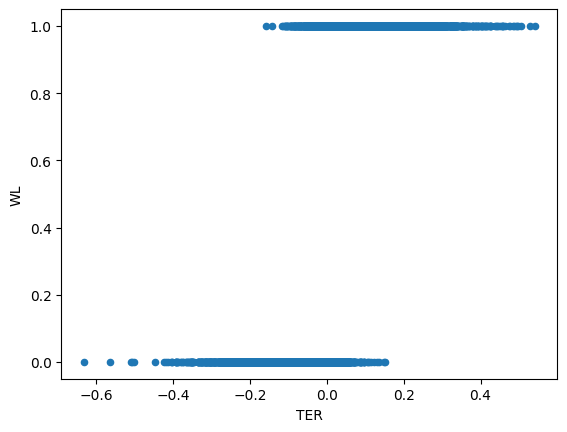

In [6]:
df = df.drop(df.index[0:(len(df) - 8000)])
# At this point, df = the latest 8000 games. Let's now use OEG formula to get our Total Effective Rating value
TER = getOER(df['PTS_HOME'], df['FGA_HOME'], df['FTA_HOME'], df['TOV_HOME']) - getOER(df['PTS_AWAY'], df['FGA_AWAY'], df['FTA_AWAY'], df['TOV_AWAY'])
df2 = pd.DataFrame()
df2['WL'] = [(0,1)[ord(str(wl)[0]) > 80] for wl in df['WL_HOME']]
df2['TER'] = [erb for erb in TER]
df2.plot.scatter(x='TER', y='WL')

## Task 3:
Now, we begin the logistic regression. We will minimize error through a cost function. Our job is to reduce cost until we have the weight vector with the minimum global cost.

First off, to check accuracy, I will be taking 1000 random data points as our test set.

If we use linear regression's cost function (Mean Squared Error) we will end up with lots of local minima, which will be difficut to traverse (non-convex). Because of this, we use the Log Loss formula.

Since we have 7k data points, I'd rather not use batch gradient descent as it'd be heavy computation. Instead, I will be doing sochastic gradient descent over all the points

The step for each iteration of SGD will occur n times, where n = 7000. In the beginning, all we have is a predictor and a cost function. The predictor function is:

$a_{n} = \sigma(w_{n - 1}x_{n} + b)$

The cost function is:

$cost = y_{n}^{a_{n}} + (1 - y_{n})^{(1 - a_{n})}$

We derive cost to get a slope. Our plan is to follow this slope until it hits zero, at which point we're at the bottom of the cost curve, aka minimum cost! Derivative of cost function is:

$DC = y_{n}log(a_{n}) + (1 - y_{n})log(1 - a_{n})$

For each iteration n we update weights depending on DC:

$w_{n} = w_{n - 1} - lr*sign*x_{n}DC$

lr = learning rate, sign = sign of $y_{n}$ (0 = -1, 1 = 1)

Let's implement this.

Step num: 5403


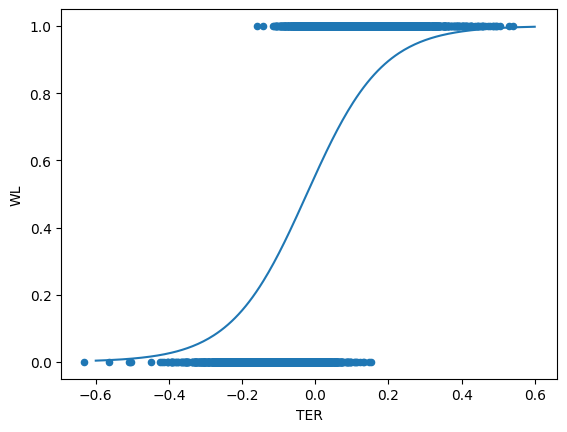

In [7]:
# grab 1k samples and shuffle the remaining 6k
testdf = df2.sample(1000)
traindf = df2.drop(testdf.index).sample(frac=1)

# turn into numpy arrays
test = testdf.to_numpy()
train = traindf.to_numpy()

# weights vector & bias
w = np.zeros(train[0].size - 1)
b = 0

# learning rate
lr = 0.05

# sigmoid formula
def sig(x):
    return 1  / (1 + math.exp(-x))

# predictor
def p(w,x,b):
    return(sig(np.dot(np.transpose(w),x) + b))

# step num
s = 0

# sgd
for pt in train:
    s += 1
    y = pt[0]
    sgn = (2*y) - 1
    x = pt[1]
    a = p(w,x,b)
    dc = y*np.log(a) + (1-y)*np.log(1-a)
    if abs(dc) < 0.01:
        print("Step num:", s)
        break
    w = w - lr*sgn*x*dc
    b = b - lr*sgn*dc
    
# plot!
x = np.linspace(-0.6,0.6,250)
y = np.zeros(250)
for i in range(0,250):
    y[i] = p(w,x[i],b)

df2.plot.scatter(x='TER', y='WL')
plt.plot(x,y)

To be honest, this came out pretty nice. The learning rate is low because there are so many data points. A surprising thing to notice is the win/loss probability crosses the 50% mark almost exactly at Total Efficiency Rating of 0.0

TER > 0 is a team with an efficiency better than their opponents. TER < 0 means their efficiency is below their opponent. The fact it flips at 0 is incredible.

In [8]:
acc = 0
for pt in test:
    a = p(w,pt[1],b)
    if(a >= 0.5 and pt[0] == 1):
        acc += a/test.size
    if(a < 0.5 and pt[0] == 0):
        acc += (1-a)/test.size
print("Accuracy:", acc)

Accuracy: 0.3254925301715031


Accuracy looks terrible, but to be honest I believe it might be because of how many datapoints live in the -0.1 to 0.1 territory.

Let's see if we can improve it though.

## Task 4:
For optimization, I decided to go with momentum and Adam. The changes are as follows.

For momentum, I need to keep track of the change each step. When I get a new step, I add a bit of the previous step. This addition is scaled by a momentum value. I'm going to try a high momentum (0.75). I will also add a condition to break once dc reaches a small enough value. I want to optimize efficiency more than accuracy.

Step num: 3952
Accuracy: 0.30781337208933146


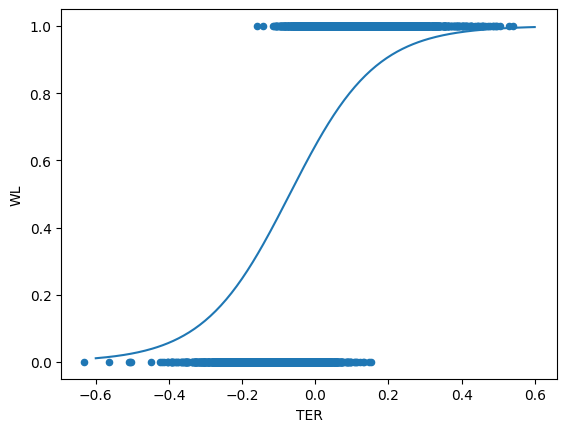

In [9]:
# reset weights vector & bias
w = np.zeros(train[0].size - 1)
b = 0

# previous change & momentum
p_change = 0
momentum = 0.75

# step no.
s = 0

# sgd
for pt in train:
    s += 1
    y = pt[0]
    sgn = (2*y) - 1
    x = pt[1]
    a = p(w,x,b)
    dc = y*np.log(a) + (1-y)*np.log(1-a)
    if abs(dc) < 0.01:
        print("Step num:", s)
        break
    change = lr*sgn*dc + momentum*p_change
    w = w - x*change
    b = b - change
    p_change = change

# plot
x = np.linspace(-0.6,0.6,250)
y = np.zeros(250)
for i in range(0,250):
    y[i] = p(w,x[i],b)

df2.plot.scatter(x='TER', y='WL')
plt.plot(x,y)

# accuracy
acc = 0
for pt in test:
    a = p(w,pt[1],b)
    if(a >= 0.5 and pt[0] == 1):
        acc += a/test.size
    if(a < 0.5 and pt[0] == 0):
        acc += (1-a)/test.size
print("Accuracy:", acc)

Using momentum I wasn't able to cut down on time efficiency by much. When running on different random sets, it is always faster than vanilla sgd, but it isn't much better. Removing 500 steps is impressive. With larger sets it's a welcome site, but momentum isn't the most advanced optimization. Let's try Adam!

I chose Adam because it stores two values. One of which is similar to momentum, so seeing it as the next step up from momentum makes sense in my mind. The values are exponentially decaying gradients, but one is squared and the other isn't.

Step num: 1658
Accuracy: 0.2788170589204749


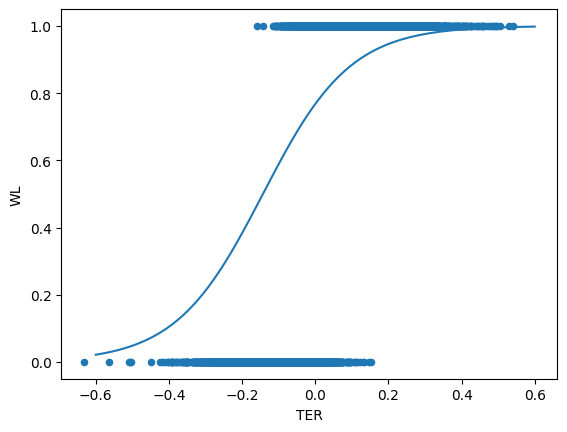

In [10]:
# reset weights vector & bias
w = np.zeros(train[0].size - 1)
b = 0

# adam momentum and squared momentum
m = 0
v = 0
m_dcay = 0.75
v_dcay = 0.9
eps = 0.000000001

# step no.
s = 0

# sgd
for pt in train:
    s += 1
    y = pt[0]
    sgn = (2*y) - 1
    x = pt[1]
    a = p(w,x,b)
    dc = y*np.log(a) + (1-y)*np.log(1-a)
    if abs(dc) < 0.01:
        print("Step num:", s)
        break
    # get new momentum
    m_new = m_dcay*m + (1-m_dcay)*dc
    v_new = v_dcay*v + (1-v_dcay)*(dc**2)
    # bias correction
    m_corr = m_new / (1 - m_dcay)
    v_corr = v_new / (1 - v_dcay)
    # update weights
    w = w - (sgn*lr*x*m_corr)/(np.sqrt(v_corr) + eps)
    b = b - (sgn*lr*m_corr)/(np.sqrt(v_corr) + eps)
    m = m_new
    v = v_new

# plot
x = np.linspace(-0.6,0.6,250)
y = np.zeros(250)
for i in range(0,250):
    y[i] = p(w,x[i],b)

df2.plot.scatter(x='TER', y='WL')
plt.plot(x,y)

# accuracy
acc = 0
for pt in test:
    a = p(w,pt[1],b)
    if(a >= 0.5 and pt[0] == 1):
        acc += a/test.size
    if(a < 0.5 and pt[0] == 0):
        acc += (1-a)/test.size
print("Accuracy:", acc)

Adam converged incredibly fast!! ~1500 steps! Thats more than half off!! I'm happy with this output, especially after how sad momentum performed. What is interesting is with each improvement in efficiency, I'm taking hits in accuracy. If I decreased convergence from 0.01 to 0.0001 I might see improvement so it's not that bad.

In the end, I don't believe optimization is needed for this problem. At least not yet. Taking this one step further, maybe adding more variables and datapoints, we'll need efficiency. Right now though, it's not adding any accuracy. This is most likely because the data isn't very seperable by just TER. There is a TON of overlap near 0.0 TER.